# Molecular dynamics from NN potentials

## 1. Datset with energy and forces

In [1]:
import numpy as np
from kgcnn.data.datasets.MD17RevisedDataset import MD17RevisedDataset

In [2]:
dataset = MD17RevisedDataset("aspirin")
print("Number of steps", len(dataset))

INFO:kgcnn.data.download:Checking and possibly downloading dataset with name MD17Revised
INFO:kgcnn.data.download:Dataset directory located at C:\Users\patri\.kgcnn\datasets
INFO:kgcnn.data.download:Dataset directory found. Done.
INFO:kgcnn.data.download:Dataset found. Done.
INFO:kgcnn.data.download:Directory for extraction exists. Done.
INFO:kgcnn.data.download:Not extracting tar File. Stopped.


Number of steps 100000


In [3]:
data = dataset[:500]
data.map_list(method="set_range", node_coordinates="coords")
data[0].keys()

dict_keys(['coords', 'energies', 'forces', 'old_indices', 'old_energies', 'old_forces', 'nuclear_charges', 'range_indices', 'range_attributes'])

In [4]:
eng = np.expand_dims(data.get("energies"), axis=-1)*0.043  # kcal/mol to eV
eng.shape, eng[0]

((500, 1), array([-17469.90164208]))

In [5]:
forces = data.tensor({"name": "forces", "ragged": True, "shape": (None, 3)})*0.043  # kcal/mol to eV
atoms = data.get("nuclear_charges")
forces[0]

<tf.Tensor: shape=(21, 3), dtype=float64, numpy=
array([[-2.74137341,  2.67700611, -0.75129579],
       [-0.90631249, -0.85888416,  2.00726686],
       [ 3.08056969, -2.19163918, -0.22727128],
       [-0.37739256,  1.81854455, -0.04203819],
       [ 0.06849278,  1.909797  ,  0.88471585],
       [-0.57261954,  0.14867004, -0.18995724],
       [ 0.22410948,  0.77632092, -2.1626258 ],
       [-0.33297714, -1.23917868, -0.10066419],
       [ 0.52634416,  3.8645722 ,  2.08451895],
       [-0.72435461,  1.99949058,  0.7122311 ],
       [ 1.25228829, -1.18763783,  0.57869244],
       [ 0.61277482, -3.80501328, -2.03832495],
       [ 1.67075583, -0.99873548, -0.52365172],
       [-0.30834985, -0.53698349,  0.41058368],
       [ 1.24551168, -1.9163207 ,  1.40335446],
       [ 0.13337422,  0.1260334 , -0.94909162],
       [-1.12054561,  0.36520689, -0.17419492],
       [-0.46182796,  0.5091511 , -0.24017999],
       [-0.29275676, -1.11448041, -0.71522209],
       [-0.47046873,  0.30675033, -0.52

In [6]:
from kgcnn.data.transform.scaler.force import EnergyForceExtensiveLabelScaler
scaler = EnergyForceExtensiveLabelScaler(standardize_coordinates=False, standardize_scale=False)  # For testing no scale.
eng, _ = scaler.fit_transform(X=None, y=eng, force=forces, atomic_number=atoms)
eng[:3]

array([[-0.09150233],
       [ 0.09685228],
       [-0.32295041]])

## 2. `EnergyForceModel` container

In [7]:
from kgcnn.model.force import EnergyForceModel

In [8]:
model_config = {
    "model_energy":{
        "module_name": "kgcnn.literature.Schnet", 
        "class_name":"make_model", 
        "config":{
            "name": "Schnet",
            "inputs": [{"shape": (None,), "name": "nuclear_charges", "dtype": "float32", "ragged": True},
                       {"shape": (None, 3), "name": "coords", "dtype": "float32", "ragged": True},
                       {"shape": (None, 2), "name": "range_indices", "dtype": "int64", "ragged": True}],
            "input_embedding": {"node": {"input_dim": 95, "output_dim": 64}},
            "make_distance": True, "expand_distance": True,
            "interaction_args": {"units": 128, "use_bias": True,
                                 "activation": "kgcnn>shifted_softplus", "cfconv_pool": "sum"},
            "node_pooling_args": {"pooling_method": "sum"},
            "depth": 4,
            "gauss_args": {"bins": 20, "distance": 4, "offset": 0.0, "sigma": 0.4},
            "verbose": 10,
            "last_mlp": {"use_bias": [True, True], "units": [128, 64],
                         "activation": ["kgcnn>shifted_softplus", "kgcnn>shifted_softplus"]},
            "output_embedding": "graph", "output_to_tensor": True,
            "use_output_mlp": True,
            "output_mlp": {"use_bias": [True, True], "units": [64, 1],
                           "activation": ["kgcnn>shifted_softplus", "linear"]}}
    },
    "output_as_dict":True,
    "output_to_tensor":False,
    "output_squeeze_states":True,
}
model = EnergyForceModel(**model_config)

INFO:kgcnn.model.utils:Updated model kwargs:
INFO:kgcnn.model.utils:{'name': 'Schnet', 'inputs': ListWrapper([DictWrapper({'shape': (None,), 'name': 'nuclear_charges', 'dtype': 'float32', 'ragged': True}), DictWrapper({'shape': (None, 3), 'name': 'coords', 'dtype': 'float32', 'ragged': True}), DictWrapper({'shape': (None, 2), 'name': 'range_indices', 'dtype': 'int64', 'ragged': True})]), 'input_embedding': {'node': {'input_dim': 95, 'output_dim': 64}}, 'make_distance': True, 'expand_distance': True, 'interaction_args': {'units': 128, 'use_bias': True, 'activation': 'kgcnn>shifted_softplus', 'cfconv_pool': 'sum'}, 'node_pooling_args': {'pooling_method': 'sum'}, 'depth': 4, 'gauss_args': {'bins': 20, 'distance': 4, 'offset': 0.0, 'sigma': 0.4}, 'verbose': 10, 'last_mlp': {'use_bias': ListWrapper([True, True]), 'units': ListWrapper([128, 64]), 'activation': ListWrapper(['kgcnn>shifted_softplus', 'kgcnn>shifted_softplus'])}, 'output_embedding': 'graph', 'output_to_tensor': True, 'use_outpu

In [9]:
x_tensor = data.tensor(model_config["model_energy"]["config"]["inputs"])
print([x.shape for x in x_tensor])

[TensorShape([500, None]), TensorShape([500, None, 3]), TensorShape([500, None, 2])]


In [10]:
test_out = model.predict(x_tensor)

C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3

16/16 [==============================] - 5s 30ms/step


In [11]:
[i.shape for i in test_out.values()]

[(500, 1), TensorShape([500, None, 3])]

In [12]:
from kgcnn.metrics.loss import RaggedMeanAbsoluteError
from tensorflow.keras.optimizers import Adam

In [13]:
model.compile(
    loss={"energy": "mean_absolute_error", "force": RaggedMeanAbsoluteError()},
    optimizer=Adam(learning_rate=5e-04),
    metrics=None,
    loss_weights=[1, 20],
)

In [14]:
hist = model.fit(
    x_tensor, {"energy": eng, "force": forces},
    shuffle=True,
    batch_size=64,
    epochs=1500,
    verbose=2,
)

Epoch 1/1500


C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape_3:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape_2:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Cast_1:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interacti

8/8 - 10s - loss: 18.9713 - energy_loss: 0.2469 - force_loss: 0.9362 - 10s/epoch - 1s/step
Epoch 2/1500
8/8 - 1s - loss: 18.9218 - energy_loss: 0.2075 - force_loss: 0.9357 - 590ms/epoch - 74ms/step
Epoch 3/1500
8/8 - 1s - loss: 18.8846 - energy_loss: 0.2060 - force_loss: 0.9339 - 591ms/epoch - 74ms/step
Epoch 4/1500
8/8 - 1s - loss: 18.7537 - energy_loss: 0.2777 - force_loss: 0.9238 - 588ms/epoch - 73ms/step
Epoch 5/1500
8/8 - 1s - loss: 18.5269 - energy_loss: 0.3421 - force_loss: 0.9092 - 628ms/epoch - 79ms/step
Epoch 6/1500
8/8 - 1s - loss: 18.3027 - energy_loss: 0.4893 - force_loss: 0.8907 - 624ms/epoch - 78ms/step
Epoch 7/1500
8/8 - 1s - loss: 17.7210 - energy_loss: 0.4253 - force_loss: 0.8648 - 598ms/epoch - 75ms/step
Epoch 8/1500
8/8 - 1s - loss: 17.5038 - energy_loss: 1.2597 - force_loss: 0.8122 - 584ms/epoch - 73ms/step
Epoch 9/1500
8/8 - 1s - loss: 18.8587 - energy_loss: 2.2512 - force_loss: 0.8304 - 586ms/epoch - 73ms/step
Epoch 10/1500
8/8 - 1s - loss: 18.0873 - energy_loss:

Epoch 78/1500
8/8 - 1s - loss: 6.4842 - energy_loss: 0.8122 - force_loss: 0.2836 - 537ms/epoch - 67ms/step
Epoch 79/1500
8/8 - 1s - loss: 6.4706 - energy_loss: 0.8350 - force_loss: 0.2818 - 555ms/epoch - 69ms/step
Epoch 80/1500
8/8 - 1s - loss: 6.4957 - energy_loss: 0.8544 - force_loss: 0.2821 - 571ms/epoch - 71ms/step
Epoch 81/1500
8/8 - 1s - loss: 6.3182 - energy_loss: 0.7459 - force_loss: 0.2786 - 555ms/epoch - 69ms/step
Epoch 82/1500
8/8 - 1s - loss: 6.4410 - energy_loss: 0.8219 - force_loss: 0.2810 - 535ms/epoch - 67ms/step
Epoch 83/1500
8/8 - 1s - loss: 6.4213 - energy_loss: 0.7672 - force_loss: 0.2827 - 539ms/epoch - 67ms/step
Epoch 84/1500
8/8 - 1s - loss: 6.6684 - energy_loss: 1.0042 - force_loss: 0.2832 - 535ms/epoch - 67ms/step
Epoch 85/1500
8/8 - 1s - loss: 6.6741 - energy_loss: 1.1967 - force_loss: 0.2739 - 545ms/epoch - 68ms/step
Epoch 86/1500
8/8 - 1s - loss: 6.9353 - energy_loss: 1.4424 - force_loss: 0.2746 - 544ms/epoch - 68ms/step
Epoch 87/1500
8/8 - 1s - loss: 6.2556

8/8 - 1s - loss: 4.7440 - energy_loss: 0.6434 - force_loss: 0.2050 - 537ms/epoch - 67ms/step
Epoch 155/1500
8/8 - 1s - loss: 4.5987 - energy_loss: 0.5175 - force_loss: 0.2041 - 538ms/epoch - 67ms/step
Epoch 156/1500
8/8 - 1s - loss: 4.6164 - energy_loss: 0.6359 - force_loss: 0.1990 - 541ms/epoch - 68ms/step
Epoch 157/1500
8/8 - 1s - loss: 4.5409 - energy_loss: 0.7323 - force_loss: 0.1904 - 539ms/epoch - 67ms/step
Epoch 158/1500
8/8 - 1s - loss: 4.3618 - energy_loss: 0.6560 - force_loss: 0.1853 - 536ms/epoch - 67ms/step
Epoch 159/1500
8/8 - 1s - loss: 4.4263 - energy_loss: 0.6528 - force_loss: 0.1887 - 540ms/epoch - 68ms/step
Epoch 160/1500
8/8 - 1s - loss: 4.3046 - energy_loss: 0.6918 - force_loss: 0.1806 - 537ms/epoch - 67ms/step
Epoch 161/1500
8/8 - 1s - loss: 4.2612 - energy_loss: 0.6386 - force_loss: 0.1811 - 538ms/epoch - 67ms/step
Epoch 162/1500
8/8 - 1s - loss: 4.3749 - energy_loss: 0.6773 - force_loss: 0.1849 - 534ms/epoch - 67ms/step
Epoch 163/1500
8/8 - 1s - loss: 4.4283 - en

Epoch 230/1500
8/8 - 1s - loss: 3.5420 - energy_loss: 0.6010 - force_loss: 0.1471 - 541ms/epoch - 68ms/step
Epoch 231/1500
8/8 - 1s - loss: 3.4272 - energy_loss: 0.4982 - force_loss: 0.1464 - 539ms/epoch - 67ms/step
Epoch 232/1500
8/8 - 1s - loss: 3.6451 - energy_loss: 0.6617 - force_loss: 0.1492 - 538ms/epoch - 67ms/step
Epoch 233/1500
8/8 - 1s - loss: 3.5113 - energy_loss: 0.5469 - force_loss: 0.1482 - 540ms/epoch - 67ms/step
Epoch 234/1500
8/8 - 1s - loss: 3.5459 - energy_loss: 0.5490 - force_loss: 0.1498 - 540ms/epoch - 67ms/step
Epoch 235/1500
8/8 - 1s - loss: 3.5805 - energy_loss: 0.5461 - force_loss: 0.1517 - 540ms/epoch - 68ms/step
Epoch 236/1500
8/8 - 1s - loss: 3.3184 - energy_loss: 0.2480 - force_loss: 0.1535 - 536ms/epoch - 67ms/step
Epoch 237/1500
8/8 - 1s - loss: 3.4448 - energy_loss: 0.5698 - force_loss: 0.1437 - 544ms/epoch - 68ms/step
Epoch 238/1500
8/8 - 1s - loss: 3.5663 - energy_loss: 0.6962 - force_loss: 0.1435 - 534ms/epoch - 67ms/step
Epoch 239/1500
8/8 - 1s - lo

Epoch 306/1500
8/8 - 1s - loss: 3.3813 - energy_loss: 0.3356 - force_loss: 0.1523 - 538ms/epoch - 67ms/step
Epoch 307/1500
8/8 - 1s - loss: 3.0972 - energy_loss: 0.2077 - force_loss: 0.1445 - 542ms/epoch - 68ms/step
Epoch 308/1500
8/8 - 1s - loss: 2.9194 - energy_loss: 0.2263 - force_loss: 0.1347 - 537ms/epoch - 67ms/step
Epoch 309/1500
8/8 - 1s - loss: 2.8058 - energy_loss: 0.2239 - force_loss: 0.1291 - 538ms/epoch - 67ms/step
Epoch 310/1500
8/8 - 1s - loss: 3.0639 - energy_loss: 0.4701 - force_loss: 0.1297 - 535ms/epoch - 67ms/step
Epoch 311/1500
8/8 - 1s - loss: 3.3808 - energy_loss: 0.5874 - force_loss: 0.1397 - 538ms/epoch - 67ms/step
Epoch 312/1500
8/8 - 1s - loss: 3.3115 - energy_loss: 0.5203 - force_loss: 0.1396 - 536ms/epoch - 67ms/step
Epoch 313/1500
8/8 - 1s - loss: 3.1534 - energy_loss: 0.5170 - force_loss: 0.1318 - 537ms/epoch - 67ms/step
Epoch 314/1500
8/8 - 1s - loss: 3.0001 - energy_loss: 0.4669 - force_loss: 0.1267 - 539ms/epoch - 67ms/step
Epoch 315/1500
8/8 - 1s - lo

Epoch 382/1500
8/8 - 1s - loss: 3.2295 - energy_loss: 0.8221 - force_loss: 0.1204 - 538ms/epoch - 67ms/step
Epoch 383/1500
8/8 - 1s - loss: 3.2760 - energy_loss: 0.8066 - force_loss: 0.1235 - 532ms/epoch - 66ms/step
Epoch 384/1500
8/8 - 1s - loss: 3.3765 - energy_loss: 0.8461 - force_loss: 0.1265 - 532ms/epoch - 66ms/step
Epoch 385/1500
8/8 - 1s - loss: 3.5042 - energy_loss: 0.7704 - force_loss: 0.1367 - 536ms/epoch - 67ms/step
Epoch 386/1500
8/8 - 1s - loss: 3.5180 - energy_loss: 0.7680 - force_loss: 0.1375 - 539ms/epoch - 67ms/step
Epoch 387/1500
8/8 - 1s - loss: 3.4510 - energy_loss: 0.8263 - force_loss: 0.1312 - 539ms/epoch - 67ms/step
Epoch 388/1500
8/8 - 1s - loss: 2.8805 - energy_loss: 0.3199 - force_loss: 0.1280 - 539ms/epoch - 67ms/step
Epoch 389/1500
8/8 - 1s - loss: 2.7880 - energy_loss: 0.4026 - force_loss: 0.1193 - 538ms/epoch - 67ms/step
Epoch 390/1500
8/8 - 1s - loss: 2.4720 - energy_loss: 0.1560 - force_loss: 0.1158 - 539ms/epoch - 67ms/step
Epoch 391/1500
8/8 - 1s - lo

Epoch 458/1500
8/8 - 1s - loss: 3.4587 - energy_loss: 1.2806 - force_loss: 0.1089 - 539ms/epoch - 67ms/step
Epoch 459/1500
8/8 - 1s - loss: 3.4586 - energy_loss: 1.2369 - force_loss: 0.1111 - 540ms/epoch - 67ms/step
Epoch 460/1500
8/8 - 1s - loss: 3.4007 - energy_loss: 1.1491 - force_loss: 0.1126 - 537ms/epoch - 67ms/step
Epoch 461/1500
8/8 - 1s - loss: 2.9028 - energy_loss: 0.4552 - force_loss: 0.1224 - 542ms/epoch - 68ms/step
Epoch 462/1500
8/8 - 1s - loss: 2.7805 - energy_loss: 0.4658 - force_loss: 0.1157 - 538ms/epoch - 67ms/step
Epoch 463/1500
8/8 - 1s - loss: 3.2491 - energy_loss: 0.8698 - force_loss: 0.1190 - 539ms/epoch - 67ms/step
Epoch 464/1500
8/8 - 1s - loss: 3.1239 - energy_loss: 0.6563 - force_loss: 0.1234 - 539ms/epoch - 67ms/step
Epoch 465/1500
8/8 - 1s - loss: 3.0897 - energy_loss: 0.4588 - force_loss: 0.1315 - 537ms/epoch - 67ms/step
Epoch 466/1500
8/8 - 1s - loss: 2.6126 - energy_loss: 0.1936 - force_loss: 0.1210 - 537ms/epoch - 67ms/step
Epoch 467/1500
8/8 - 1s - lo

Epoch 534/1500
8/8 - 1s - loss: 2.0711 - energy_loss: 0.1439 - force_loss: 0.0964 - 535ms/epoch - 67ms/step
Epoch 535/1500
8/8 - 1s - loss: 2.3964 - energy_loss: 0.4081 - force_loss: 0.0994 - 536ms/epoch - 67ms/step
Epoch 536/1500
8/8 - 1s - loss: 2.5040 - energy_loss: 0.4570 - force_loss: 0.1024 - 541ms/epoch - 68ms/step
Epoch 537/1500
8/8 - 1s - loss: 2.3096 - energy_loss: 0.1979 - force_loss: 0.1056 - 540ms/epoch - 67ms/step
Epoch 538/1500
8/8 - 1s - loss: 2.2731 - energy_loss: 0.1754 - force_loss: 0.1049 - 538ms/epoch - 67ms/step
Epoch 539/1500
8/8 - 1s - loss: 2.2182 - energy_loss: 0.1919 - force_loss: 0.1013 - 536ms/epoch - 67ms/step
Epoch 540/1500
8/8 - 1s - loss: 2.1564 - energy_loss: 0.1712 - force_loss: 0.0993 - 537ms/epoch - 67ms/step
Epoch 541/1500
8/8 - 1s - loss: 2.1167 - energy_loss: 0.1636 - force_loss: 0.0977 - 539ms/epoch - 67ms/step
Epoch 542/1500
8/8 - 1s - loss: 2.1247 - energy_loss: 0.1711 - force_loss: 0.0977 - 535ms/epoch - 67ms/step
Epoch 543/1500
8/8 - 1s - lo

Epoch 610/1500
8/8 - 1s - loss: 2.0610 - energy_loss: 0.1893 - force_loss: 0.0936 - 539ms/epoch - 67ms/step
Epoch 611/1500
8/8 - 1s - loss: 2.0687 - energy_loss: 0.2211 - force_loss: 0.0924 - 537ms/epoch - 67ms/step
Epoch 612/1500
8/8 - 1s - loss: 2.0135 - energy_loss: 0.1862 - force_loss: 0.0914 - 536ms/epoch - 67ms/step
Epoch 613/1500
8/8 - 1s - loss: 2.0724 - energy_loss: 0.2212 - force_loss: 0.0926 - 535ms/epoch - 67ms/step
Epoch 614/1500
8/8 - 1s - loss: 2.6987 - energy_loss: 0.8294 - force_loss: 0.0935 - 537ms/epoch - 67ms/step
Epoch 615/1500
8/8 - 1s - loss: 2.4897 - energy_loss: 0.5219 - force_loss: 0.0984 - 535ms/epoch - 67ms/step
Epoch 616/1500
8/8 - 1s - loss: 2.7002 - energy_loss: 0.7256 - force_loss: 0.0987 - 538ms/epoch - 67ms/step
Epoch 617/1500
8/8 - 1s - loss: 2.6710 - energy_loss: 0.4996 - force_loss: 0.1086 - 539ms/epoch - 67ms/step
Epoch 618/1500
8/8 - 1s - loss: 2.5910 - energy_loss: 0.3556 - force_loss: 0.1118 - 539ms/epoch - 67ms/step
Epoch 619/1500
8/8 - 1s - lo

Epoch 686/1500
8/8 - 1s - loss: 1.9959 - energy_loss: 0.2579 - force_loss: 0.0869 - 540ms/epoch - 67ms/step
Epoch 687/1500
8/8 - 1s - loss: 2.0398 - energy_loss: 0.2988 - force_loss: 0.0871 - 539ms/epoch - 67ms/step
Epoch 688/1500
8/8 - 1s - loss: 1.8858 - energy_loss: 0.1782 - force_loss: 0.0854 - 536ms/epoch - 67ms/step
Epoch 689/1500
8/8 - 1s - loss: 1.9270 - energy_loss: 0.1879 - force_loss: 0.0870 - 537ms/epoch - 67ms/step
Epoch 690/1500
8/8 - 1s - loss: 1.9084 - energy_loss: 0.1741 - force_loss: 0.0867 - 535ms/epoch - 67ms/step
Epoch 691/1500
8/8 - 1s - loss: 2.1128 - energy_loss: 0.3723 - force_loss: 0.0870 - 538ms/epoch - 67ms/step
Epoch 692/1500
8/8 - 1s - loss: 2.1805 - energy_loss: 0.4023 - force_loss: 0.0889 - 543ms/epoch - 68ms/step
Epoch 693/1500
8/8 - 1s - loss: 2.2791 - energy_loss: 0.4151 - force_loss: 0.0932 - 539ms/epoch - 67ms/step
Epoch 694/1500
8/8 - 1s - loss: 2.1894 - energy_loss: 0.3997 - force_loss: 0.0895 - 534ms/epoch - 67ms/step
Epoch 695/1500
8/8 - 1s - lo

Epoch 762/1500
8/8 - 1s - loss: 1.9690 - energy_loss: 0.2024 - force_loss: 0.0883 - 540ms/epoch - 68ms/step
Epoch 763/1500
8/8 - 1s - loss: 2.1458 - energy_loss: 0.3794 - force_loss: 0.0883 - 539ms/epoch - 67ms/step
Epoch 764/1500
8/8 - 1s - loss: 2.2278 - energy_loss: 0.3935 - force_loss: 0.0917 - 543ms/epoch - 68ms/step
Epoch 765/1500
8/8 - 1s - loss: 2.2220 - energy_loss: 0.3952 - force_loss: 0.0913 - 536ms/epoch - 67ms/step
Epoch 766/1500
8/8 - 1s - loss: 2.1882 - energy_loss: 0.3710 - force_loss: 0.0909 - 540ms/epoch - 68ms/step
Epoch 767/1500
8/8 - 1s - loss: 2.1408 - energy_loss: 0.2868 - force_loss: 0.0927 - 537ms/epoch - 67ms/step
Epoch 768/1500
8/8 - 1s - loss: 2.3316 - energy_loss: 0.3752 - force_loss: 0.0978 - 536ms/epoch - 67ms/step
Epoch 769/1500
8/8 - 1s - loss: 2.3192 - energy_loss: 0.3421 - force_loss: 0.0989 - 534ms/epoch - 67ms/step
Epoch 770/1500
8/8 - 1s - loss: 2.3064 - energy_loss: 0.3804 - force_loss: 0.0963 - 538ms/epoch - 67ms/step
Epoch 771/1500
8/8 - 1s - lo

Epoch 838/1500
8/8 - 1s - loss: 1.7821 - energy_loss: 0.1744 - force_loss: 0.0804 - 538ms/epoch - 67ms/step
Epoch 839/1500
8/8 - 1s - loss: 1.8449 - energy_loss: 0.2025 - force_loss: 0.0821 - 538ms/epoch - 67ms/step
Epoch 840/1500
8/8 - 1s - loss: 2.3252 - energy_loss: 0.6812 - force_loss: 0.0822 - 538ms/epoch - 67ms/step
Epoch 841/1500
8/8 - 1s - loss: 2.0883 - energy_loss: 0.3748 - force_loss: 0.0857 - 537ms/epoch - 67ms/step
Epoch 842/1500
8/8 - 1s - loss: 2.0027 - energy_loss: 0.2791 - force_loss: 0.0862 - 536ms/epoch - 67ms/step
Epoch 843/1500
8/8 - 1s - loss: 2.1375 - energy_loss: 0.3087 - force_loss: 0.0914 - 535ms/epoch - 67ms/step
Epoch 844/1500
8/8 - 1s - loss: 2.0290 - energy_loss: 0.1849 - force_loss: 0.0922 - 536ms/epoch - 67ms/step
Epoch 845/1500
8/8 - 1s - loss: 2.1340 - energy_loss: 0.3499 - force_loss: 0.0892 - 539ms/epoch - 67ms/step
Epoch 846/1500
8/8 - 1s - loss: 1.9279 - energy_loss: 0.1993 - force_loss: 0.0864 - 536ms/epoch - 67ms/step
Epoch 847/1500
8/8 - 1s - lo

Epoch 914/1500
8/8 - 1s - loss: 1.7545 - energy_loss: 0.1737 - force_loss: 0.0790 - 539ms/epoch - 67ms/step
Epoch 915/1500
8/8 - 1s - loss: 1.7612 - energy_loss: 0.1742 - force_loss: 0.0793 - 538ms/epoch - 67ms/step
Epoch 916/1500
8/8 - 1s - loss: 1.8669 - energy_loss: 0.1623 - force_loss: 0.0852 - 537ms/epoch - 67ms/step
Epoch 917/1500
8/8 - 1s - loss: 1.8900 - energy_loss: 0.3232 - force_loss: 0.0783 - 539ms/epoch - 67ms/step
Epoch 918/1500
8/8 - 1s - loss: 1.8680 - energy_loss: 0.3305 - force_loss: 0.0769 - 534ms/epoch - 67ms/step
Epoch 919/1500
8/8 - 1s - loss: 2.0568 - energy_loss: 0.4649 - force_loss: 0.0796 - 539ms/epoch - 67ms/step
Epoch 920/1500
8/8 - 1s - loss: 2.2571 - energy_loss: 0.6224 - force_loss: 0.0817 - 540ms/epoch - 67ms/step
Epoch 921/1500
8/8 - 1s - loss: 2.2567 - energy_loss: 0.5824 - force_loss: 0.0837 - 540ms/epoch - 67ms/step
Epoch 922/1500
8/8 - 1s - loss: 1.7756 - energy_loss: 0.1915 - force_loss: 0.0792 - 535ms/epoch - 67ms/step
Epoch 923/1500
8/8 - 1s - lo

Epoch 990/1500
8/8 - 1s - loss: 2.0121 - energy_loss: 0.3454 - force_loss: 0.0833 - 539ms/epoch - 67ms/step
Epoch 991/1500
8/8 - 1s - loss: 2.0610 - energy_loss: 0.3781 - force_loss: 0.0841 - 537ms/epoch - 67ms/step
Epoch 992/1500
8/8 - 1s - loss: 1.8918 - energy_loss: 0.3309 - force_loss: 0.0780 - 537ms/epoch - 67ms/step
Epoch 993/1500
8/8 - 1s - loss: 1.9012 - energy_loss: 0.3630 - force_loss: 0.0769 - 536ms/epoch - 67ms/step
Epoch 994/1500
8/8 - 1s - loss: 1.7982 - energy_loss: 0.2911 - force_loss: 0.0754 - 536ms/epoch - 67ms/step
Epoch 995/1500
8/8 - 1s - loss: 1.8387 - energy_loss: 0.2944 - force_loss: 0.0772 - 535ms/epoch - 67ms/step
Epoch 996/1500
8/8 - 1s - loss: 1.9464 - energy_loss: 0.3483 - force_loss: 0.0799 - 537ms/epoch - 67ms/step
Epoch 997/1500
8/8 - 1s - loss: 1.8999 - energy_loss: 0.3250 - force_loss: 0.0787 - 534ms/epoch - 67ms/step
Epoch 998/1500
8/8 - 1s - loss: 2.2058 - energy_loss: 0.3463 - force_loss: 0.0930 - 539ms/epoch - 67ms/step
Epoch 999/1500
8/8 - 1s - lo

Epoch 1066/1500
8/8 - 1s - loss: 1.5724 - energy_loss: 0.1594 - force_loss: 0.0707 - 540ms/epoch - 68ms/step
Epoch 1067/1500
8/8 - 1s - loss: 1.5753 - energy_loss: 0.1531 - force_loss: 0.0711 - 544ms/epoch - 68ms/step
Epoch 1068/1500
8/8 - 1s - loss: 1.5477 - energy_loss: 0.1478 - force_loss: 0.0700 - 538ms/epoch - 67ms/step
Epoch 1069/1500
8/8 - 1s - loss: 1.6850 - energy_loss: 0.2731 - force_loss: 0.0706 - 540ms/epoch - 67ms/step
Epoch 1070/1500
8/8 - 1s - loss: 1.5970 - energy_loss: 0.1606 - force_loss: 0.0718 - 535ms/epoch - 67ms/step
Epoch 1071/1500
8/8 - 1s - loss: 1.6023 - energy_loss: 0.1566 - force_loss: 0.0723 - 541ms/epoch - 68ms/step
Epoch 1072/1500
8/8 - 1s - loss: 1.5700 - energy_loss: 0.1466 - force_loss: 0.0712 - 541ms/epoch - 68ms/step
Epoch 1073/1500
8/8 - 1s - loss: 1.5471 - energy_loss: 0.1456 - force_loss: 0.0701 - 536ms/epoch - 67ms/step
Epoch 1074/1500
8/8 - 1s - loss: 1.6011 - energy_loss: 0.2078 - force_loss: 0.0697 - 546ms/epoch - 68ms/step
Epoch 1075/1500
8/8

Epoch 1142/1500
8/8 - 1s - loss: 1.5015 - energy_loss: 0.1519 - force_loss: 0.0675 - 538ms/epoch - 67ms/step
Epoch 1143/1500
8/8 - 1s - loss: 1.5170 - energy_loss: 0.1631 - force_loss: 0.0677 - 534ms/epoch - 67ms/step
Epoch 1144/1500
8/8 - 1s - loss: 1.6096 - energy_loss: 0.2701 - force_loss: 0.0670 - 539ms/epoch - 67ms/step
Epoch 1145/1500
8/8 - 1s - loss: 1.6141 - energy_loss: 0.2077 - force_loss: 0.0703 - 534ms/epoch - 67ms/step
Epoch 1146/1500
8/8 - 1s - loss: 1.8687 - energy_loss: 0.3241 - force_loss: 0.0772 - 538ms/epoch - 67ms/step
Epoch 1147/1500
8/8 - 1s - loss: 1.9396 - energy_loss: 0.3060 - force_loss: 0.0817 - 539ms/epoch - 67ms/step
Epoch 1148/1500
8/8 - 1s - loss: 1.8707 - energy_loss: 0.3203 - force_loss: 0.0775 - 537ms/epoch - 67ms/step
Epoch 1149/1500
8/8 - 1s - loss: 1.8802 - energy_loss: 0.3434 - force_loss: 0.0768 - 533ms/epoch - 67ms/step
Epoch 1150/1500
8/8 - 1s - loss: 1.8777 - energy_loss: 0.3154 - force_loss: 0.0781 - 535ms/epoch - 67ms/step
Epoch 1151/1500
8/8

Epoch 1218/1500
8/8 - 1s - loss: 1.7252 - energy_loss: 0.3280 - force_loss: 0.0699 - 538ms/epoch - 67ms/step
Epoch 1219/1500
8/8 - 1s - loss: 1.8325 - energy_loss: 0.3466 - force_loss: 0.0743 - 537ms/epoch - 67ms/step
Epoch 1220/1500
8/8 - 1s - loss: 1.8844 - energy_loss: 0.2867 - force_loss: 0.0799 - 543ms/epoch - 68ms/step
Epoch 1221/1500
8/8 - 1s - loss: 1.7971 - energy_loss: 0.2950 - force_loss: 0.0751 - 540ms/epoch - 67ms/step
Epoch 1222/1500
8/8 - 1s - loss: 1.5461 - energy_loss: 0.1337 - force_loss: 0.0706 - 539ms/epoch - 67ms/step
Epoch 1223/1500
8/8 - 1s - loss: 1.5417 - energy_loss: 0.1257 - force_loss: 0.0708 - 539ms/epoch - 67ms/step
Epoch 1224/1500
8/8 - 1s - loss: 1.4998 - energy_loss: 0.1464 - force_loss: 0.0677 - 539ms/epoch - 67ms/step
Epoch 1225/1500
8/8 - 1s - loss: 1.7286 - energy_loss: 0.2932 - force_loss: 0.0718 - 538ms/epoch - 67ms/step
Epoch 1226/1500
8/8 - 1s - loss: 1.7171 - energy_loss: 0.1680 - force_loss: 0.0775 - 541ms/epoch - 68ms/step
Epoch 1227/1500
8/8

Epoch 1294/1500
8/8 - 1s - loss: 1.7675 - energy_loss: 0.3841 - force_loss: 0.0692 - 540ms/epoch - 68ms/step
Epoch 1295/1500
8/8 - 1s - loss: 1.6513 - energy_loss: 0.2727 - force_loss: 0.0689 - 537ms/epoch - 67ms/step
Epoch 1296/1500
8/8 - 1s - loss: 1.4985 - energy_loss: 0.1447 - force_loss: 0.0677 - 533ms/epoch - 67ms/step
Epoch 1297/1500
8/8 - 1s - loss: 1.4246 - energy_loss: 0.1371 - force_loss: 0.0644 - 532ms/epoch - 66ms/step
Epoch 1298/1500
8/8 - 1s - loss: 1.4532 - energy_loss: 0.1364 - force_loss: 0.0658 - 535ms/epoch - 67ms/step
Epoch 1299/1500
8/8 - 1s - loss: 1.6072 - energy_loss: 0.3033 - force_loss: 0.0652 - 544ms/epoch - 68ms/step
Epoch 1300/1500
8/8 - 1s - loss: 1.6432 - energy_loss: 0.2893 - force_loss: 0.0677 - 543ms/epoch - 68ms/step
Epoch 1301/1500
8/8 - 1s - loss: 1.6189 - energy_loss: 0.3237 - force_loss: 0.0648 - 543ms/epoch - 68ms/step
Epoch 1302/1500
8/8 - 1s - loss: 1.6557 - energy_loss: 0.3161 - force_loss: 0.0670 - 547ms/epoch - 68ms/step
Epoch 1303/1500
8/8

Epoch 1370/1500
8/8 - 1s - loss: 1.4959 - energy_loss: 0.1797 - force_loss: 0.0658 - 536ms/epoch - 67ms/step
Epoch 1371/1500
8/8 - 1s - loss: 1.5994 - energy_loss: 0.2493 - force_loss: 0.0675 - 534ms/epoch - 67ms/step
Epoch 1372/1500
8/8 - 1s - loss: 1.5421 - energy_loss: 0.1355 - force_loss: 0.0703 - 540ms/epoch - 68ms/step
Epoch 1373/1500
8/8 - 1s - loss: 1.4878 - energy_loss: 0.1701 - force_loss: 0.0659 - 532ms/epoch - 66ms/step
Epoch 1374/1500
8/8 - 1s - loss: 1.6781 - energy_loss: 0.3416 - force_loss: 0.0668 - 534ms/epoch - 67ms/step
Epoch 1375/1500
8/8 - 1s - loss: 1.6420 - energy_loss: 0.2954 - force_loss: 0.0673 - 529ms/epoch - 66ms/step
Epoch 1376/1500
8/8 - 1s - loss: 1.6712 - energy_loss: 0.3237 - force_loss: 0.0674 - 541ms/epoch - 68ms/step
Epoch 1377/1500
8/8 - 1s - loss: 1.6785 - energy_loss: 0.3084 - force_loss: 0.0685 - 534ms/epoch - 67ms/step
Epoch 1378/1500
8/8 - 1s - loss: 1.8083 - energy_loss: 0.2794 - force_loss: 0.0764 - 535ms/epoch - 67ms/step
Epoch 1379/1500
8/8

Epoch 1446/1500
8/8 - 1s - loss: 1.7149 - energy_loss: 0.3324 - force_loss: 0.0691 - 536ms/epoch - 67ms/step
Epoch 1447/1500
8/8 - 1s - loss: 1.6447 - energy_loss: 0.3109 - force_loss: 0.0667 - 536ms/epoch - 67ms/step
Epoch 1448/1500
8/8 - 1s - loss: 1.6222 - energy_loss: 0.3141 - force_loss: 0.0654 - 535ms/epoch - 67ms/step
Epoch 1449/1500
8/8 - 1s - loss: 1.6097 - energy_loss: 0.3022 - force_loss: 0.0654 - 534ms/epoch - 67ms/step
Epoch 1450/1500
8/8 - 1s - loss: 1.5616 - energy_loss: 0.2947 - force_loss: 0.0633 - 537ms/epoch - 67ms/step
Epoch 1451/1500
8/8 - 1s - loss: 1.5570 - energy_loss: 0.3047 - force_loss: 0.0626 - 539ms/epoch - 67ms/step
Epoch 1452/1500
8/8 - 1s - loss: 1.5638 - energy_loss: 0.3068 - force_loss: 0.0629 - 535ms/epoch - 67ms/step
Epoch 1453/1500
8/8 - 1s - loss: 1.5015 - energy_loss: 0.3005 - force_loss: 0.0601 - 537ms/epoch - 67ms/step
Epoch 1454/1500
8/8 - 1s - loss: 1.5238 - energy_loss: 0.2956 - force_loss: 0.0614 - 537ms/epoch - 67ms/step
Epoch 1455/1500
8/8

In [15]:
from kgcnn.utils.plots import plot_train_test_loss

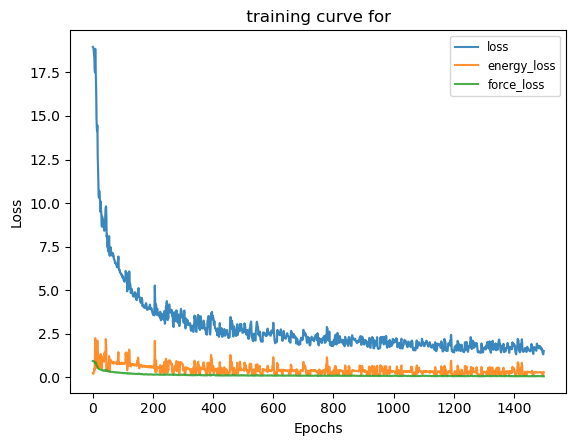

In [16]:
plot_train_test_loss([hist]);

## 3. `MolDynamicsModelPredictor` wrapping pre- and postprocessing

In [17]:
from kgcnn.moldyn.base import MolDynamicsModelPredictor
from kgcnn.graph.postprocessor import ExtensiveEnergyForceScalerPostprocessor
from kgcnn.graph.preprocessor import SetRange

In [18]:
dyn_model = MolDynamicsModelPredictor(
    model=model, 
    model_inputs=model_config["model_energy"]["config"]["inputs"], 
    model_outputs={"energy":"energy", "forces": "force"},
    graph_preprocessors=[SetRange(node_coordinates="coords", overwrite=False)],  # To use 
    graph_postprocessors=[
        ExtensiveEnergyForceScalerPostprocessor(
            scaler, energy="energy", force="forces", atomic_number="nuclear_charges")],
    store_last_input=True,
    update_from_last_input=["range_indices"],  # and "range_images" if periodic.
    update_from_last_input_skip=3    
)

In [19]:
dyn_model(dataset[0:510])[0]

C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3

{'energy': array([-17469.68873145]),
 'forces': array([[-2.7796206 ,  2.6814184 , -0.8565141 ],
        [-0.87467015, -0.8907675 ,  2.032208  ],
        [ 3.0396042 , -2.1803386 , -0.14517796],
        [-0.40727887,  1.676504  , -0.05313331],
        [ 0.03868783,  1.846242  ,  0.8305312 ],
        [-0.604615  ,  0.32339573, -0.10664749],
        [ 0.32481095,  0.62650126, -2.1985285 ],
        [-0.33968252, -1.196799  , -0.0957547 ],
        [ 0.5091632 ,  3.8894641 ,  2.0367835 ],
        [-0.69470227,  2.1020963 ,  0.68470895],
        [ 1.2158593 , -1.2081629 ,  0.46906552],
        [ 0.52596194, -3.8267732 , -1.8822132 ],
        [ 1.713852  , -0.9879772 , -0.548269  ],
        [-0.2534808 , -0.56990135,  0.40728897],
        [ 1.1667396 , -1.8820128 ,  1.381889  ],
        [ 0.08915559,  0.2839395 , -0.8586236 ],
        [-1.1431459 ,  0.38288987, -0.16244656],
        [-0.4371866 ,  0.4497682 , -0.226673  ],
        [-0.27660653, -1.1132725 , -0.7225786 ],
        [-0.38273826, 

## 4. Use ASE compatible `KgcnnSingleCalculator`

In [20]:
from ase import Atoms
from kgcnn.moldyn.ase_calc import KgcnnSingleCalculator, AtomsToGraphConverter

In [21]:
atoms = Atoms(dataset[0]["nuclear_charges"], positions=dataset[0]["coords"])
atoms

Atoms(symbols='C7O3C2OH8', pbc=False)

In [22]:
conv=AtomsToGraphConverter({"nuclear_charges": "get_atomic_numbers", "coords": "get_positions"})
conv(atoms)

<MemoryGraphList [{'nuclear_charges': array([6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 6, 6, 8, 1, 1, 1, 1, 1, 1, 1, 1]), 'coords': array([[ 2.15275078, -0.93790121, -0.05378575],
       [ 0.99956719,  1.13262738, -1.67300307],
       [ 2.73218273, -0.44859684, -1.19275553],
       [ 2.14794307,  0.41880283, -2.08405233],
       [-3.15705489,  1.42240939,  0.33067654],
       [ 0.91168856, -0.33727827,  0.29772754],
       [ 0.36105629,  0.72618343, -0.42339745],
       [-0.40166094, -0.12259909,  2.26219435],
       [-2.13128849, -0.48888369, -0.80224462],
       [ 0.29867456, -2.24990948,  1.44246368],
       [ 0.1239993 , -0.83296539,  1.42230211],
       [-2.04596577,  0.64616435, -0.22107209],
       [-0.88096468,  1.36265193, -0.06099633],
       [-0.02472582, -2.46371902,  2.33402192],
       [ 2.47956412, -1.70739289,  0.55101985],
       [ 0.49126967,  1.99943374, -2.09234064],
       [ 3.77819263, -0.85891833, -1.40897491],
       [ 2.75656656,  0.58901616, -2.98423316],
       [-2.82095

In [23]:
calc = KgcnnSingleCalculator(model_predictor=dyn_model, atoms_converter=conv)
calc

In [24]:
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase import units

In [25]:
atoms.calc = calc
calc.calculate(atoms)
print(calc.results)

# Set the momenta corresponding to T=300K
MaxwellBoltzmannDistribution(atoms, temperature_K=300)

# We want to run MD with constant energy using the VelocityVerlet algorithm.
dyn = VelocityVerlet(atoms, 1 * units.fs)  # 5 fs time step.

C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3/sch_net_c_fconv_3/pooling_local_edges_3/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(
C:\Users\patri\anaconda3\envs\gcnn_keras_test\lib\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/energy_force_model/model/sch_net_interaction_3

{'energy': array(-17469.68873191), 'forces': array([[-2.7796206 ,  2.6814194 , -0.8565145 ],
       [-0.87467   , -0.8907682 ,  2.0322099 ],
       [ 3.0396042 , -2.1803384 , -0.1451776 ],
       [-0.40727806,  1.676503  , -0.05313301],
       [ 0.03868771,  1.8462422 ,  0.83053136],
       [-0.6046134 ,  0.32339603, -0.10664684],
       [ 0.3248111 ,  0.62650216, -2.1985304 ],
       [-0.33968228, -1.1967996 , -0.09575408],
       [ 0.5091631 ,  3.8894641 ,  2.036783  ],
       [-0.6947024 ,  2.102098  ,  0.68470925],
       [ 1.2158597 , -1.208164  ,  0.46906728],
       [ 0.5259631 , -3.8267727 , -1.8822135 ],
       [ 1.7138517 , -0.987978  , -0.5482693 ],
       [-0.25348073, -0.56990135,  0.40728867],
       [ 1.1667401 , -1.8820124 ,  1.3818895 ],
       [ 0.08915544,  0.28393936, -0.8586234 ],
       [-1.1431459 ,  0.38288963, -0.1624465 ],
       [-0.4371866 ,  0.4497683 , -0.22667317],
       [-0.27660677, -1.1132728 , -0.7225788 ],
       [-0.38273823,  0.2629518 , -0.515471

In [26]:
def printenergy(a):
    """Function to print the potential, kinetic and total energy"""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))


# Now run the dynamics
printenergy(atoms)
for i in range(20):
    dyn.run(10)
    printenergy(atoms)

Energy per atom: Epot = -831.890eV  Ekin = 0.038eV (T=292K)  Etot = -831.852eV
Energy per atom: Epot = -831.907eV  Ekin = 0.054eV (T=420K)  Etot = -831.852eV
Energy per atom: Epot = -831.892eV  Ekin = 0.040eV (T=309K)  Etot = -831.852eV
Energy per atom: Epot = -831.900eV  Ekin = 0.048eV (T=375K)  Etot = -831.851eV
Energy per atom: Epot = -831.896eV  Ekin = 0.056eV (T=432K)  Etot = -831.840eV
Energy per atom: Epot = -831.906eV  Ekin = 0.058eV (T=448K)  Etot = -831.848eV
Energy per atom: Epot = -831.898eV  Ekin = 0.052eV (T=405K)  Etot = -831.846eV
Energy per atom: Epot = -831.905eV  Ekin = 0.054eV (T=421K)  Etot = -831.850eV
Energy per atom: Epot = -831.896eV  Ekin = 0.046eV (T=352K)  Etot = -831.850eV
Energy per atom: Epot = -831.903eV  Ekin = 0.052eV (T=406K)  Etot = -831.850eV
Energy per atom: Epot = -831.907eV  Ekin = 0.055eV (T=425K)  Etot = -831.852eV
Energy per atom: Epot = -831.901eV  Ekin = 0.049eV (T=378K)  Etot = -831.852eV
Energy per atom: Epot = -831.901eV  Ekin = 0.051eV (

In [27]:
calc.model_predictor._last_input

<MemoryGraphList [{'nuclear_charges': array([6, 6, 6, 6, 6, 6, 6, 8, 8, 8, 6, 6, 8, 1, 1, 1, 1, 1, 1, 1, 1]), 'coords': array([[ 1.60780091, -1.15371636, -0.66257908],
       [ 0.90075856,  1.42428059, -1.67190699],
       [ 2.1444262 , -0.71244301, -1.91840966],
       [ 1.67911392,  0.56131762, -2.46787226],
       [-2.76014808,  2.03770766,  0.91236715],
       [ 0.80579413, -0.30975933,  0.16582702],
       [ 0.45392154,  0.99004733, -0.39365848],
       [-0.64769403, -0.26606384,  2.20474226],
       [-2.11814078,  1.32708737, -1.3082589 ],
       [ 1.0908183 , -1.58731654,  2.09706802],
       [ 0.3106117 , -0.65623023,  1.55447469],
       [-1.80004339,  1.63979461, -0.23356277],
       [-0.48057862,  1.66737367,  0.31290185],
       [ 0.59739834, -2.07126744,  2.79081232],
       [ 1.82858929, -2.072723  , -0.25410023],
       [ 0.515401  ,  2.29236007, -2.18426825],
       [ 2.88552604, -1.4216933 , -2.42296907],
       [ 1.82518668,  0.86541102, -3.50138529],
       [-3.77763

In [28]:
dyn_model._test_timing(conv(atoms))

0.05625